# UMAPs Neurips samples, NK cells

In this notebook UMAPs are generated from latent space. Leiden clusters are calculated  and highly expressed genes/markers are searched using scanpy rank_genes_groups -function.


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scvi
import scanpy as sc
import umap

from ridgeplot import ridgeplot
from pySankey import sankey

import warnings

warnings.filterwarnings('ignore')



# 1. Preparations

In [64]:
#Neurips

adata = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_neurips_norm_outer.h5ad')

In [65]:
adata = adata.copy()

In [66]:
#Both NK cell types selected  + one sample is selected

adata = adata[(adata.obs['cell_type'] == "NK") | (adata.obs['cell_type'] == "NK CD158e1+")]

In [67]:
#Selecting only one sample

adata =adata[adata.obs['POOL'] == "s4d1"]

In [68]:
adata.shape

(665, 21720)

In [69]:
#protein information saved

adata_prot=adata.obsm['protein_expression_clr_neurips']

In [70]:
#Neurips, latent

adata_latent = adata.copy()

In [71]:
adata_latent

AnnData object with n_obs × n_vars = 665 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

# Leiden clusters

In [72]:
#Removing MALAT1 and mito + ribo genes from adata_gex

#MALAT1 is more or less technical finding => remove

#malat1 = adata_gex.var_names.str.startswith('MALAT1')

#genes to be removed
mito_genes = adata_latent.var_names.str.startswith('MT-')
ribo_genes = adata_latent.var_names.str.startswith('RPL')
ribo_genes1 = adata_latent.var_names.str.startswith('RPS')

remove = np.add(mito_genes, ribo_genes)
remove = np.add(remove, ribo_genes1)

#other genes kept
keep = np.invert(remove)

adata_latent = adata_latent[:,keep]

#print(adata_gex.n_obs, adata_gex.n_vars)

In [73]:
#Calculating neighbors for UMAPs

sc.pp.neighbors(adata_latent, use_rep="X_totalVI")    

sc.tl.umap(adata_latent)


In [74]:
#Calculating leidens for latent object
sc.tl.leiden(adata_latent, resolution = 0.2, key_added = "leiden_0.2")
sc.tl.leiden(adata_latent, resolution = 0.4, key_added = "leiden_0.4")
sc.tl.leiden(adata_latent, resolution = 0.6, key_added = "leiden_0_6")



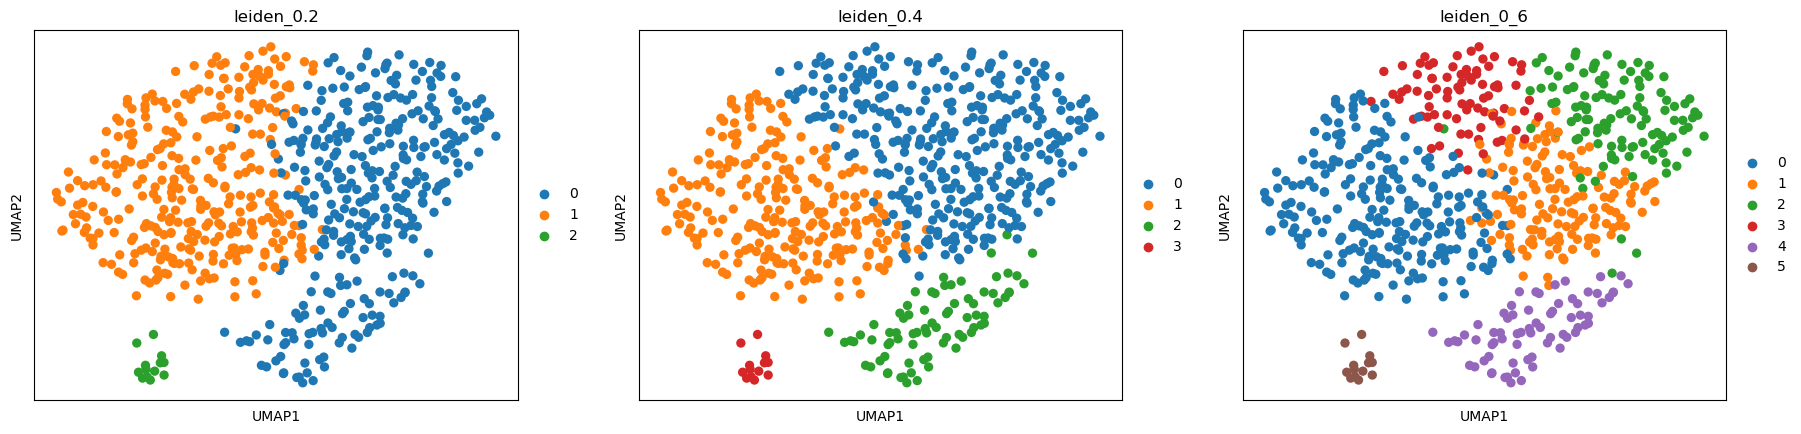

In [75]:
#Showing results in UMAPs

sc.pl.umap(adata_latent, color=['leiden_0.2', 'leiden_0.4', 'leiden_0_6'], ncols =3)


### Subclustering 

Cluster 4 is further clustered to find tissue-resident NK cell population

In [76]:
orig_key = 'leiden_0_6' 
new_key = 'leiden_0_6'
new_rg_key = 'rg_res0_6_sub'
sub_key = '4'

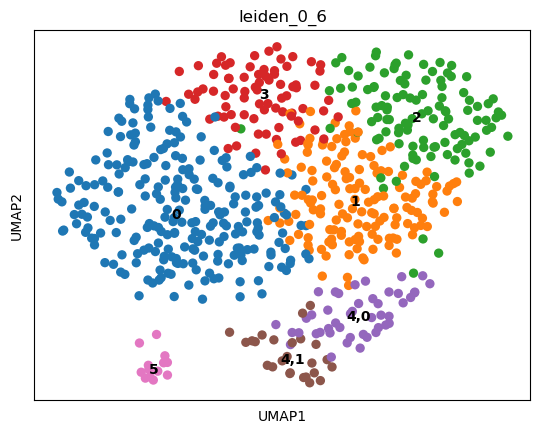

0      241
1      147
2      115
3       79
4,0     45
4,1     25
5       13
Name: leiden_0_6, dtype: int64

In [77]:
res = 0.3
sc.tl.leiden(adata_latent, restrict_to=(orig_key, [sub_key]), key_added=new_key, resolution=res)
sc.pl.umap(adata_latent, color=new_key, legend_loc = 'on data')
adata_latent.obs[new_key].value_counts()

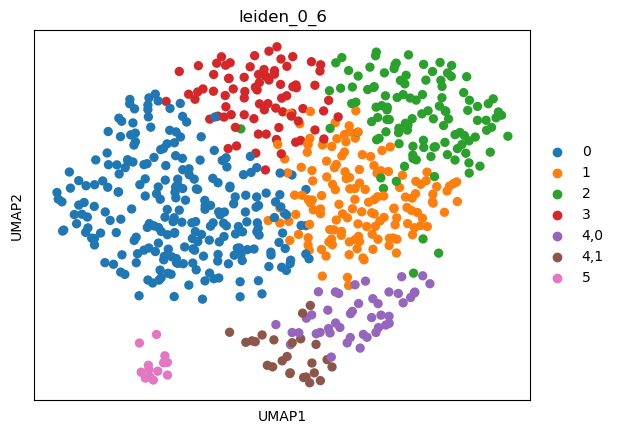

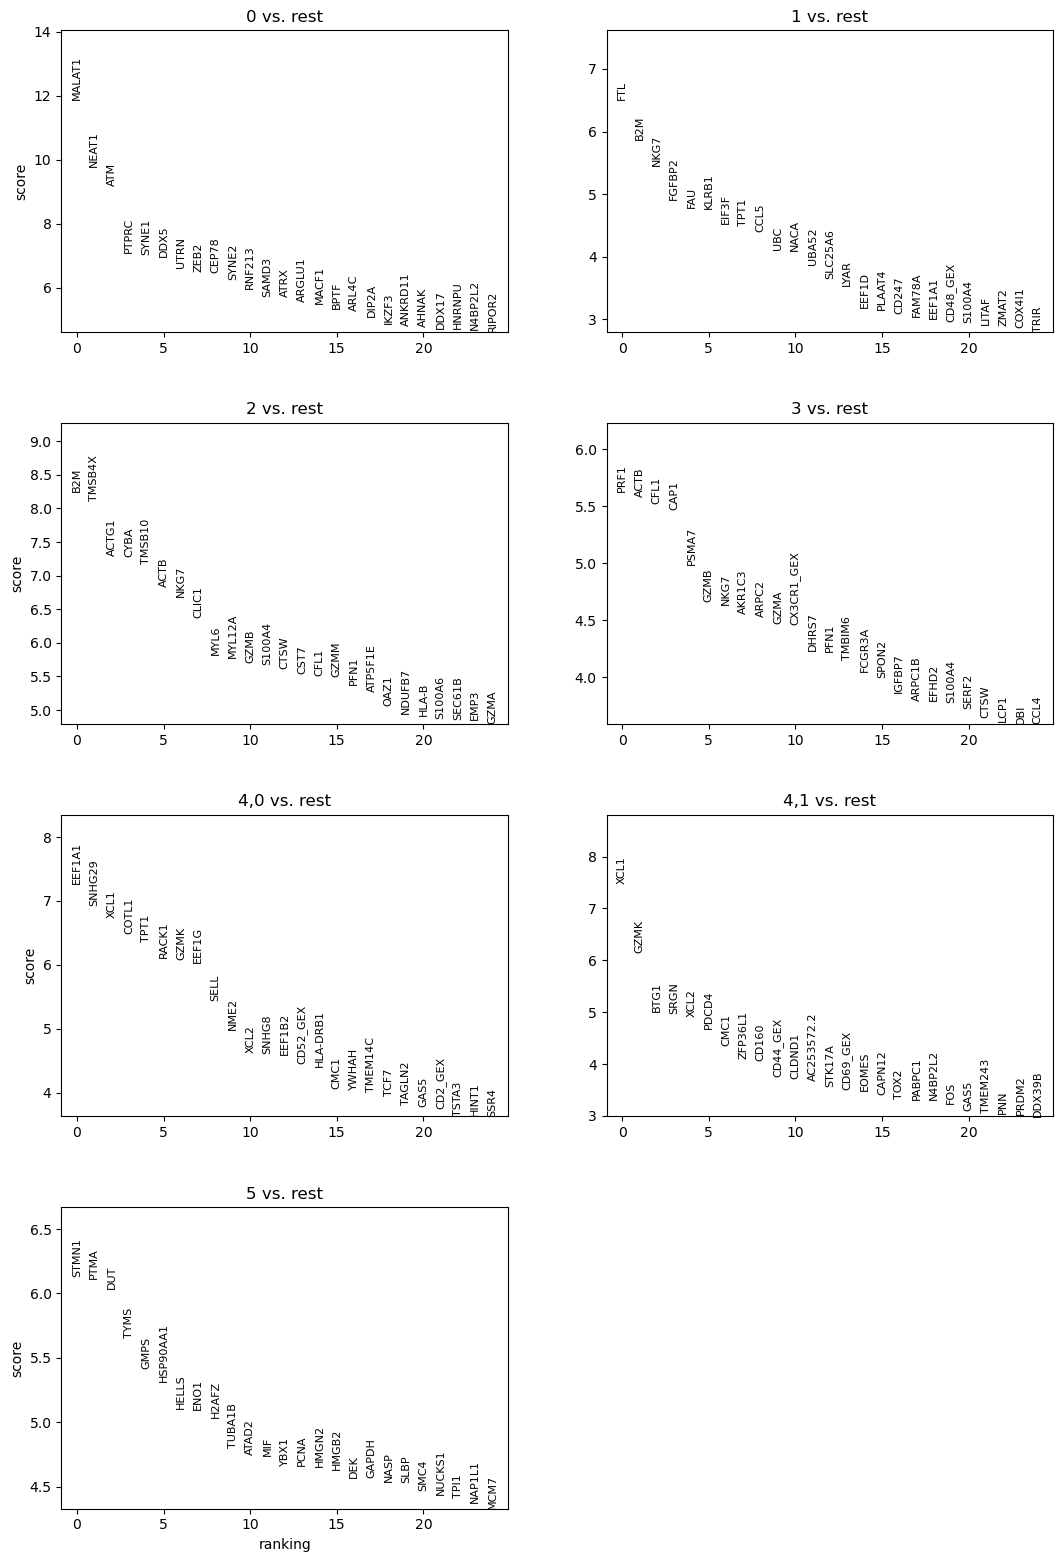

In [78]:
#Latent

sc.pl.umap(adata_latent, color=['leiden_0_6'])
sc.tl.rank_genes_groups(adata_latent, 'leiden_0_6', method='wilcoxon')
sc.pl.rank_genes_groups(adata_latent, n_genes=25, sharey=False, ncols=2)

In [106]:
#7 clusters: turkoosi, violetti, keltainen, vihreä, oranssi, tumma sininen

cols = ['#43CD80', '#7FFFD4', '#BF3EFF', '#FFEC8B', '#FFC1C1', '#FFA500', '#4169E1']

In [107]:
adata_latent.uns['leiden_0_6_colors'] = cols

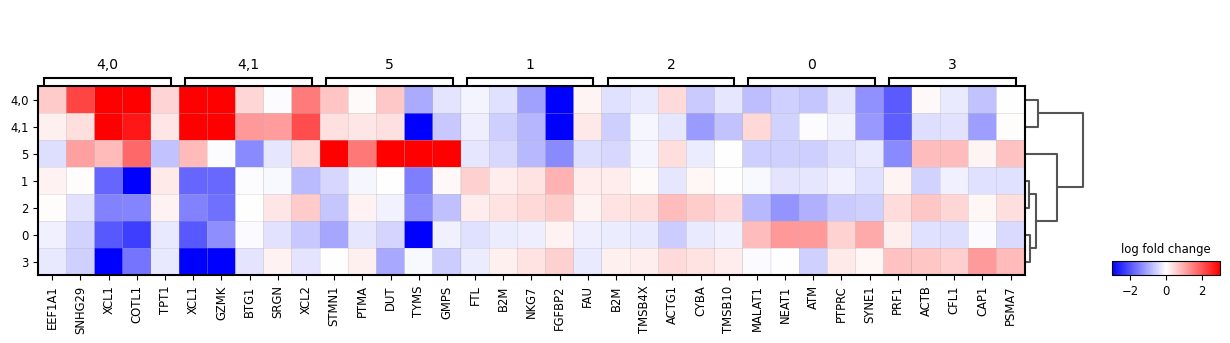

In [108]:
sc.pl.rank_genes_groups_matrixplot(adata_latent, n_genes=5, use_raw=False, values_to_plot="logfoldchanges", colorbar_title='log fold change', vmin=-3, vmax=3, cmap='bwr')

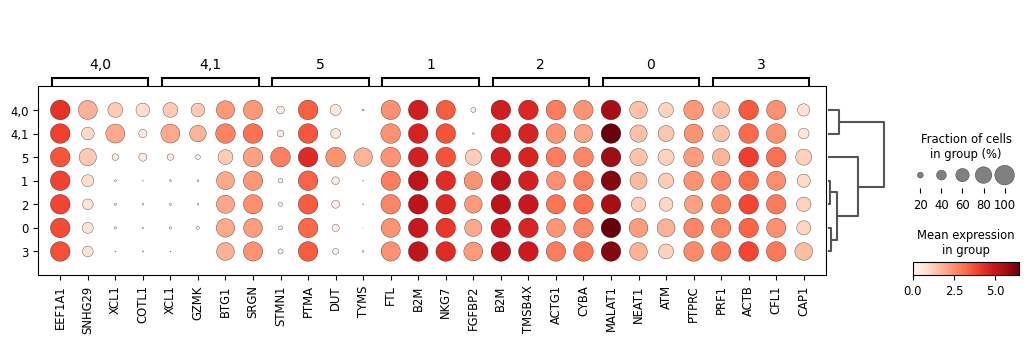

In [87]:
sc.pl.rank_genes_groups_dotplot(adata_latent, n_genes=4)

categories: 0, 1, 2, etc.
var_group_labels: 0, 1, 2, etc.


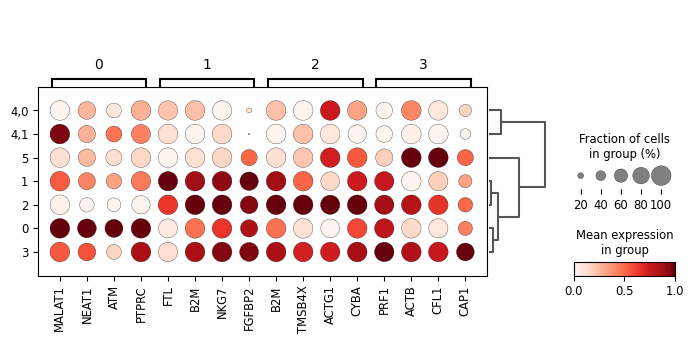

In [101]:
# standard_scale='var' => scaled values

sc.pl.rank_genes_groups_dotplot(adata_latent, n_genes=4, groups=['0','1','2', '3'], standard_scale='var')

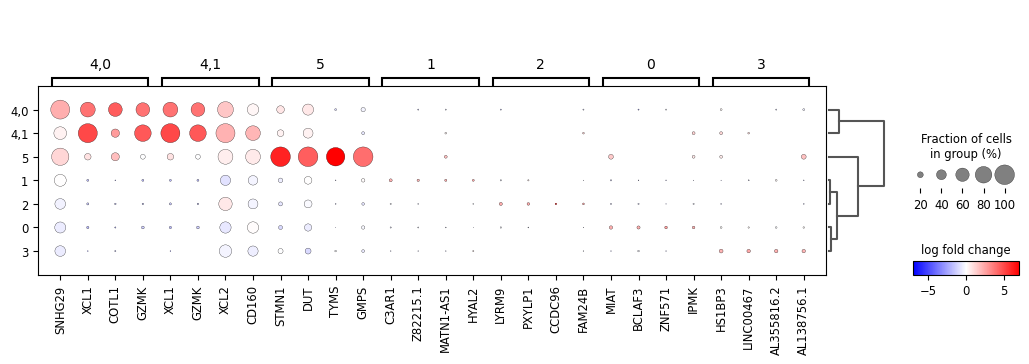

In [94]:
sc.pl.rank_genes_groups_dotplot(adata_latent, n_genes=4, values_to_plot='logfoldchanges', min_logfoldchange=2, vmax=7, vmin=-7, cmap='bwr')


categories: 0, 1, 2, etc.
var_group_labels: 0, 1, 2, etc.


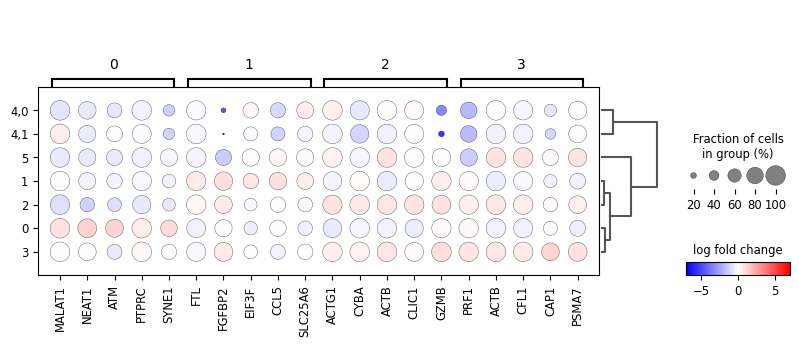

In [103]:
sc.pl.rank_genes_groups_dotplot(adata_latent, n_genes=5, values_to_plot='logfoldchanges', min_logfoldchange=0.5, vmax=7, vmin=-7, cmap='bwr', groups=['0','1','2', '3'])


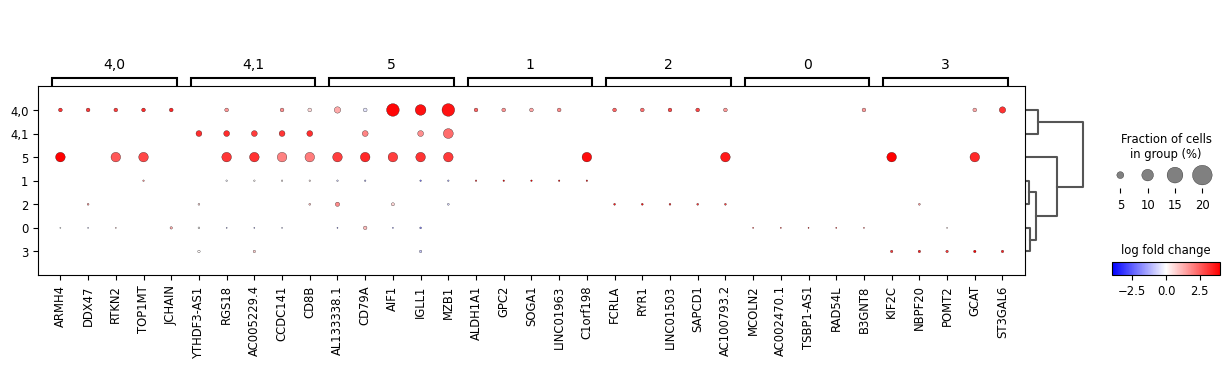

In [104]:
#plotting last 5 genes

sc.pl.rank_genes_groups_dotplot(
    adata_latent,
    n_genes=-5,
    values_to_plot="logfoldchanges",
    cmap='bwr',
    vmin=-4,
    vmax=4,
    min_logfoldchange=3,
    colorbar_title='log fold change',
)

In [ ]:
var_names = {'T-cell': ['CD3D', 'CD3E', 'IL32'],
              'B-cell': ['CD79A', 'CD79B', 'MS4A1'],
              'myeloid': ['CST3', 'LYZ'] }
sc.pl.rank_genes_groups_dotplot(
    adata,
    var_names=var_names,
    values_to_plot="logfoldchanges",
    cmap='bwr',
    vmin=-4,
    vmax=4,
    min_logfoldchange=3,
    colorbar_title='log fold change',
)

In [55]:
adata_latent

AnnData object with n_obs × n_vars = 665 × 21604
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'leiden_0.2', 'leiden_0.4', 'leiden_0_6', 'CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40', 'CD154', 'CD52', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7_prot', 'CD105', 'CD49f', 'CD194', 'C

- Cluster 0:??  NEAT1 is a long-noncoding RNA. SYNE1, SYNE2 => innate immune response?
- Cluster 1: B2M, NKG7, GZMB, PRF1 => mature CD56dim (Huuhtanen, Yang).
- Cluster 2: Mature NK (similar to cluster 1) 
- Cluster 3: ZEB2, CX3CR1 => terminal NK (Yang) 
- Cluster 4: GZMK, XCL1, SELL (CD62L) => Immature CD56bright
- Cluster 4,1: tissue-resident NK (CD160, CD69). 
- Cluster 5: proliferating NK. STM1, TYMS, HMGB2, H2FZ (Melsen).

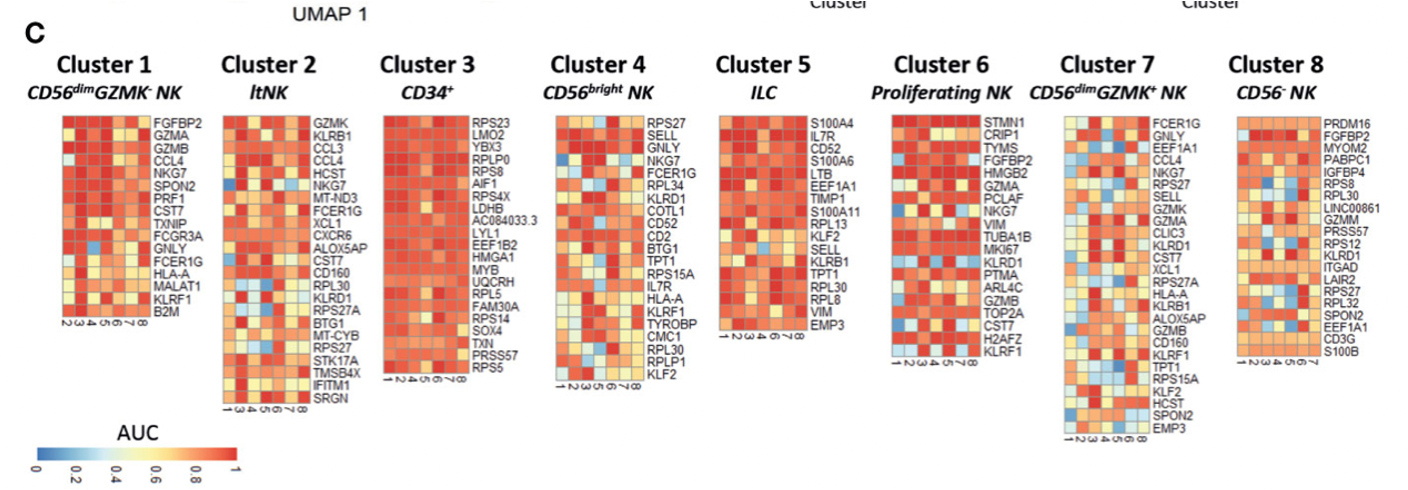
(Melsen et al. 2022)


- Clusters 1, 2, 4, 6, 7 of above figure were found also in other datasets (Crinier + Yang) 

In [110]:
prot_1 = adata_latent.obsm['protein_expression_clr_neurips']

In [111]:
#some proteins and genes have same names, here _prot added after protein names

prot_1=prot_1.rename(columns={'CD2': 'CD2_prot', 'KLRG1': 'KLRG_prot', 'CX3CR1': 'CX3CR1_prot', 'CD226':'CD226_prot', 'TIGIT':'TIGIT_prot', 'CD27':'CD27_prot', 'CD34': 'CD34_prot', 'CD38': 'CD38_prot', 'CD224': 'CD224_prot', 'CD7': 'CD7_prot', 'CD44': 'CD44_prot', 'CD5': 'CD5_prot'})

In [112]:
#adding protein information to obs

a = adata_latent.obs
b = prot_1

adata1=pd.concat([a, b], axis=1)
adata_latent.obs=adata1

adata_latent

AnnData object with n_obs × n_vars = 665 × 21604
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'leiden_0.2', 'leiden_0.4', 'leiden_0_6', 'CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40', 'CD154', 'CD52', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7_prot', 'CD105', 'CD49f', 'CD194', 'C

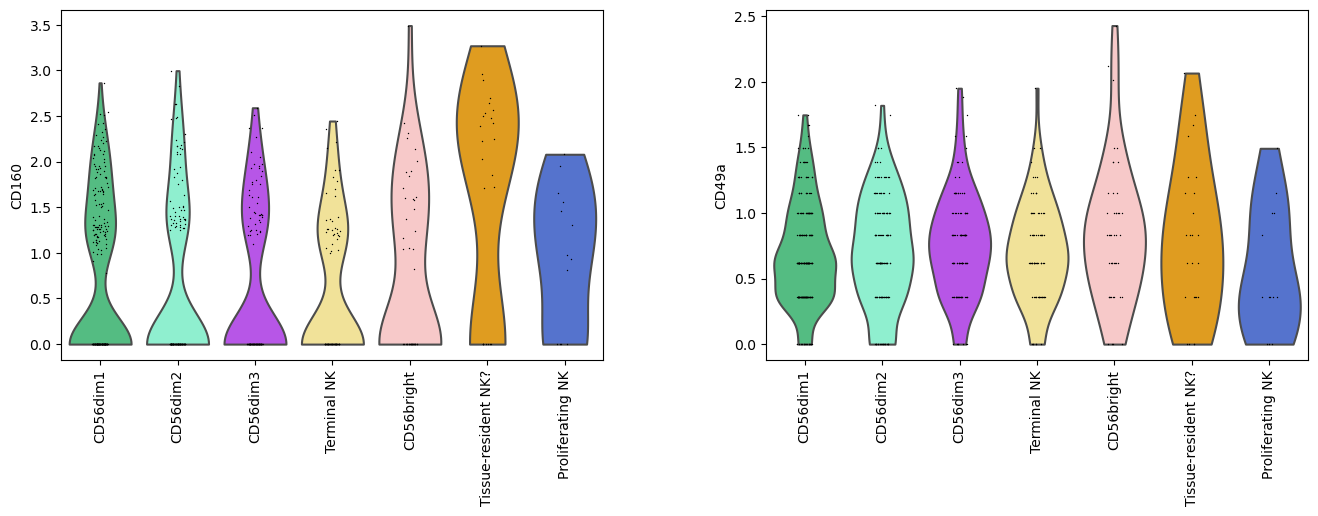

In [117]:


sc.pl.violin(adata_latent, ['CD160', 'CD49a'], groupby='leiden_0_6', rotation=90)

- "Core Trm gene expression signatures including upregulation of the integrin ITGAE (CD103), ITGA1, and the chemokine receptor CXCR6 and downregulation of tissue egress molecules S1PR1 and KLF2" 

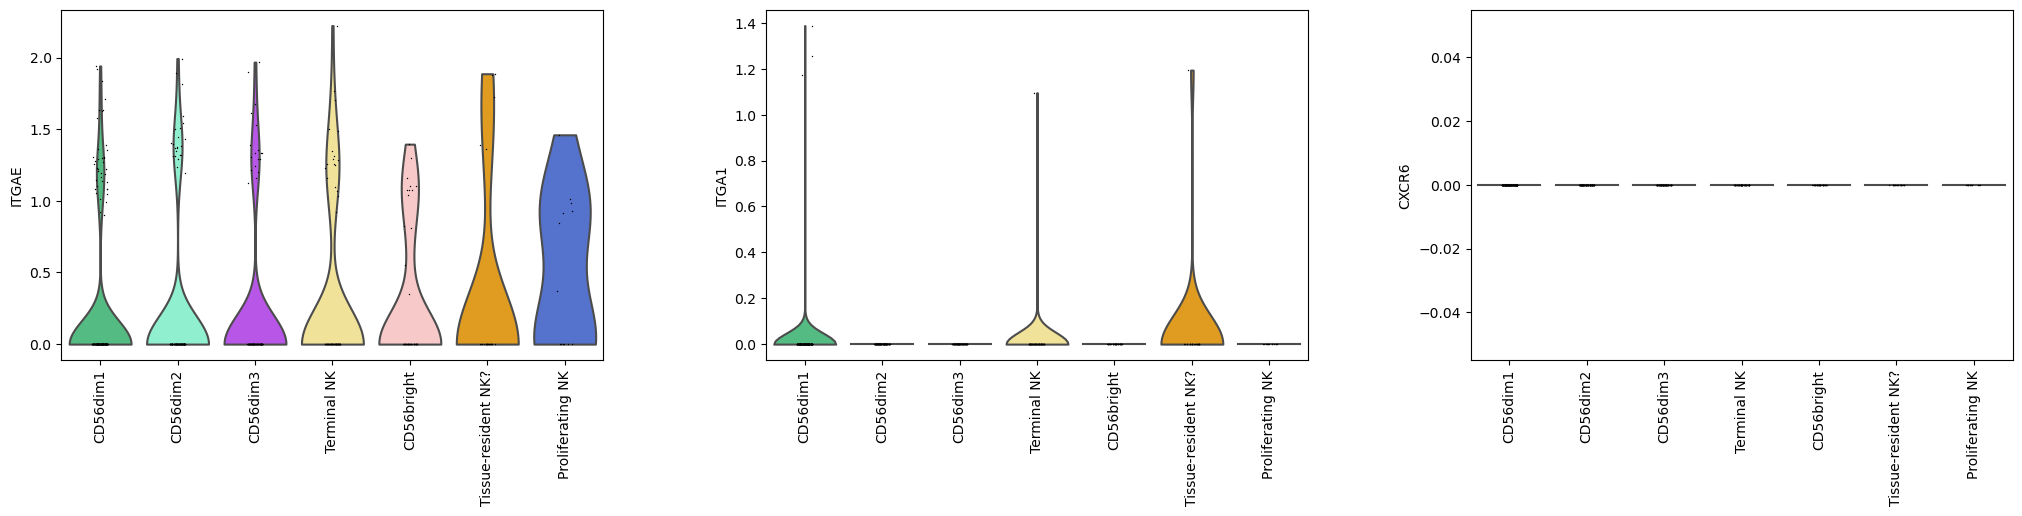

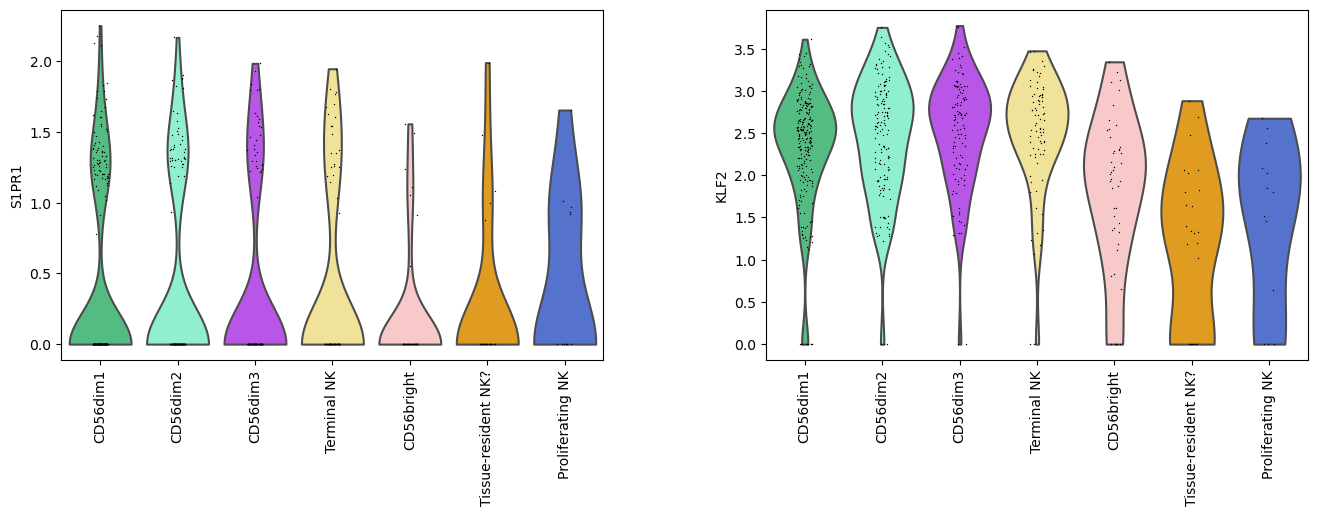

In [118]:
sc.pl.violin(adata_latent, ['ITGAE', 'ITGA1', 'CXCR6'], groupby='leiden_0_6', rotation=90)

sc.pl.violin(adata_latent, ['S1PR1', 'KLF2'], groupby='leiden_0_6', rotation= 90)

## Cell cycle scoring

- Genes identified by Nestorowa et al., Blood 2016
- link to download https://satijalab.org/seurat/archive/v3.1/cell_cycle_vignette.html

- To verify that cluster 5 represents proliferating NK cells, cell cycle scores were calculated for all cells. 

In [23]:
#list of genes

cell_cycle_genes = [x.strip() for x in open('/Users/tiinatuononen/Desktop/Thesis/Project/data/cell_cycle_vignette_files/regev_lab_cell_cycle_genes.txt')]

In [24]:
#defining two lists, s-phase genes and g2m genes

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata_latent.var_names]

In [25]:
#calculating scores

sc.tl.score_genes_cell_cycle(adata_latent, s_genes=s_genes, g2m_genes=g2m_genes)

In [26]:
adata_latent

AnnData object with n_obs × n_vars = 665 × 21604
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'leiden_0.2', 'leiden_0.4', 'leiden_0_6', 'CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40', 'CD154', 'CD52', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7_prot', 'CD105', 'CD49f', 'CD194', 'C

In [27]:
#Calculating neighbors for UMAP

sc.pp.neighbors(adata_latent, use_rep="X_totalVI")   

sc.tl.umap(adata_latent)


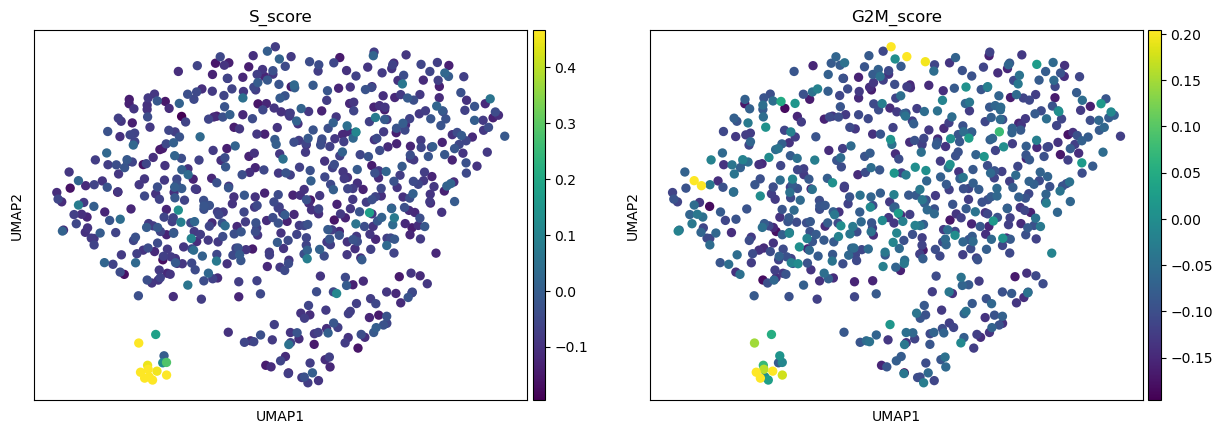

In [28]:
sc.pl.umap(adata_latent, color = ['S_score', 'G2M_score'], vmax="p99", color_map = 'viridis', ncols = 3)



- Confirm that cluster 5 is proliferating NK

## Leiden clustering with higher resolution

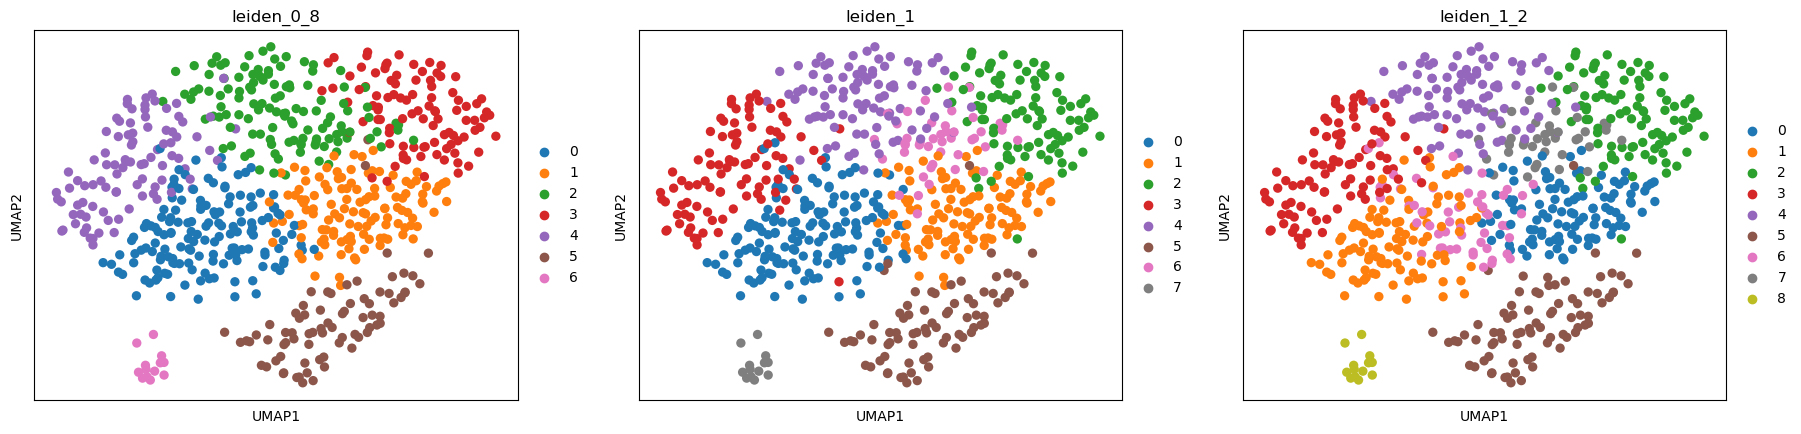

In [29]:
sc.tl.leiden(adata_latent, resolution = 0.8, key_added = "leiden_0_8")
sc.tl.leiden(adata_latent, resolution = 1.0, key_added = "leiden_1")
sc.tl.leiden(adata_latent, resolution = 1.2, key_added = "leiden_1_2")

sc.pl.umap(adata_latent, color=['leiden_0_8', 'leiden_1', 'leiden_1_2'], ncols =3)

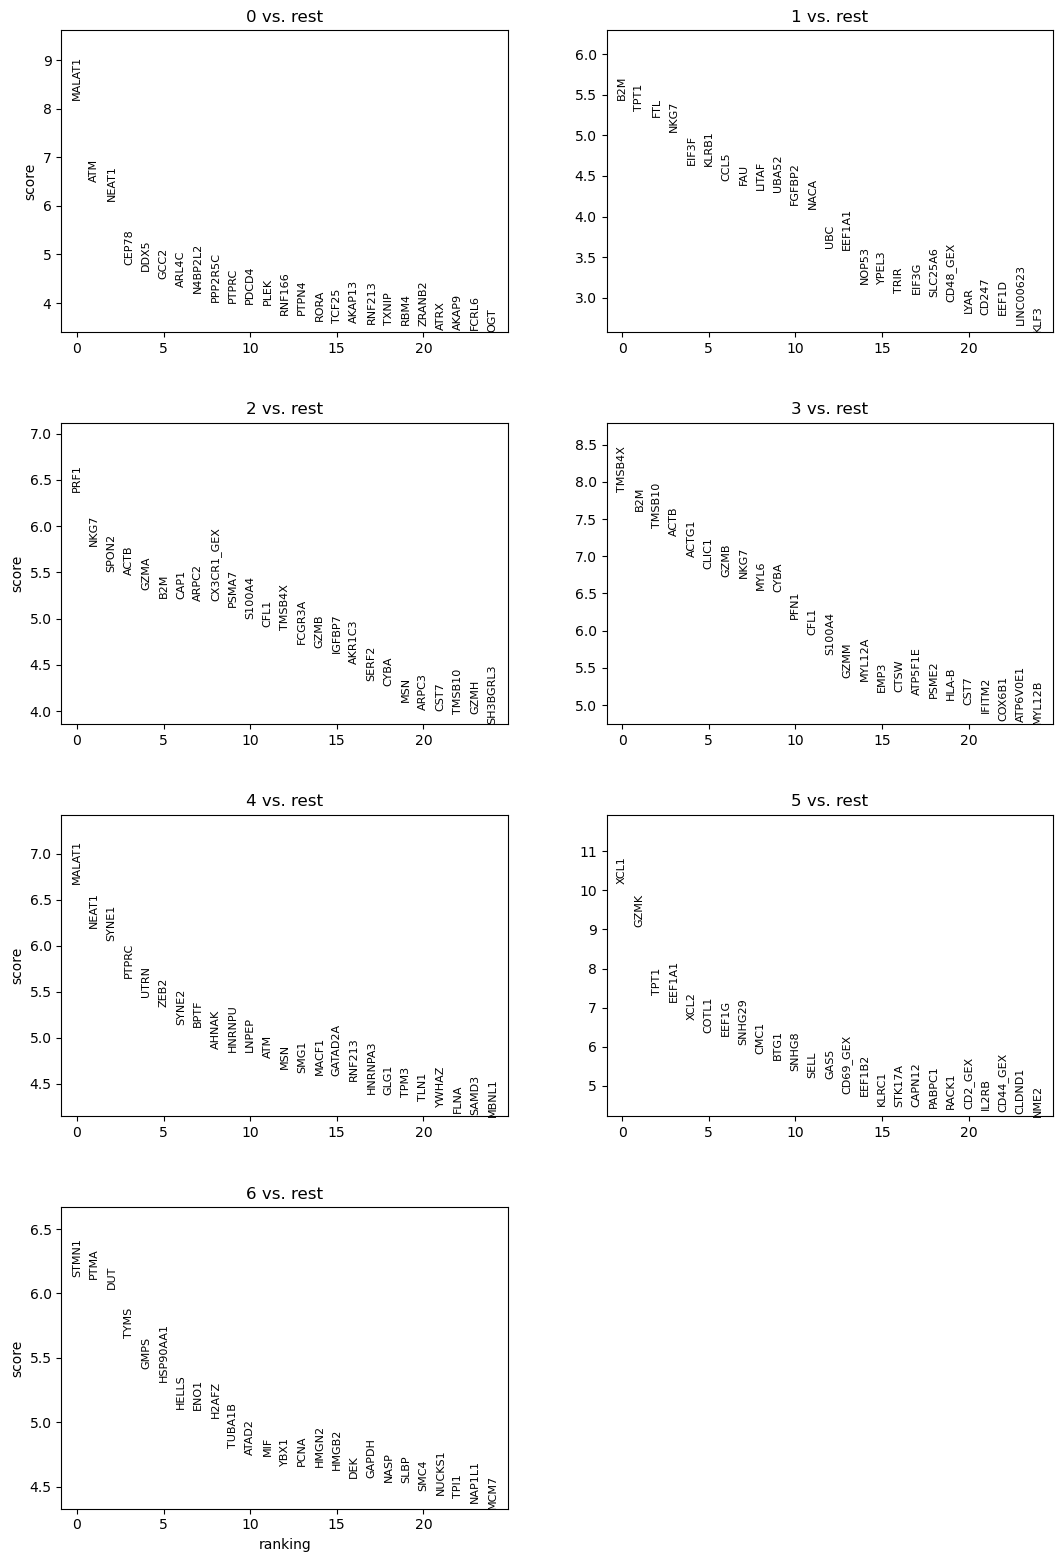

In [30]:
sc.tl.rank_genes_groups(adata_latent, 'leiden_0_8', method='wilcoxon')
sc.pl.rank_genes_groups(adata_latent, n_genes=25, sharey=False, ncols=2)

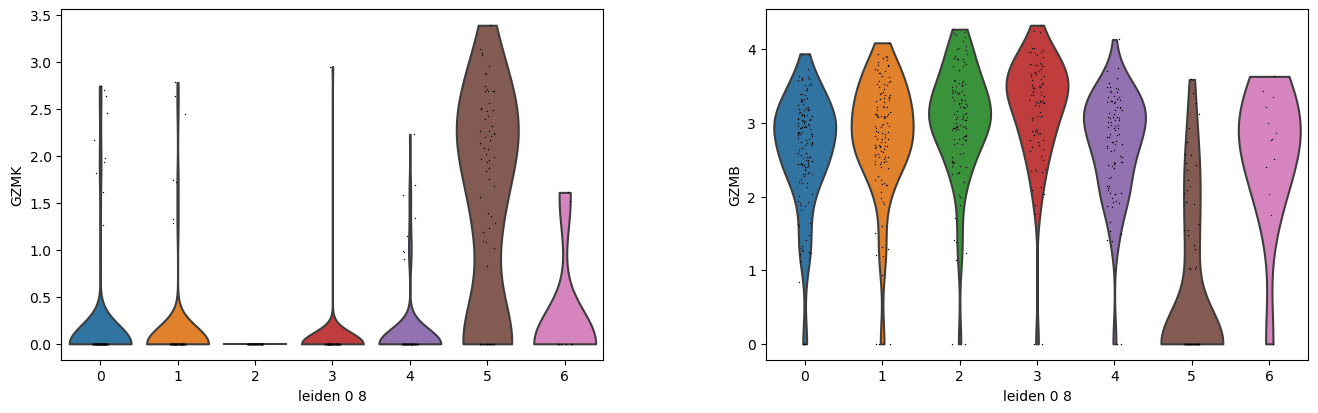

In [31]:
sc.pl.violin(adata_latent, ['GZMK', 'GZMB'], groupby='leiden_0_8')

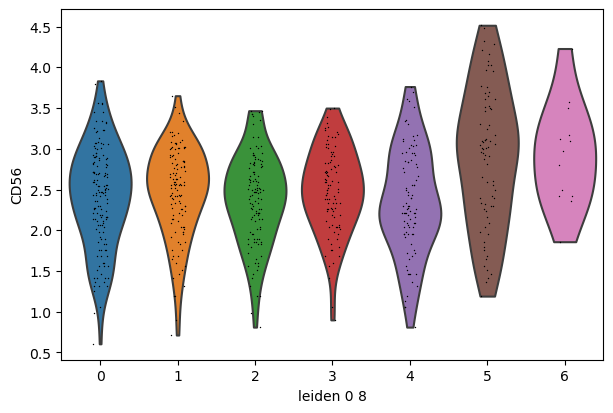

In [32]:
sc.pl.violin(adata_latent, ['CD56'], groupby='leiden_0_8')

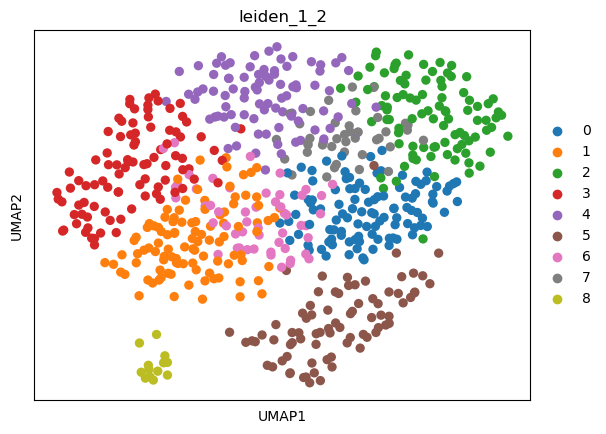

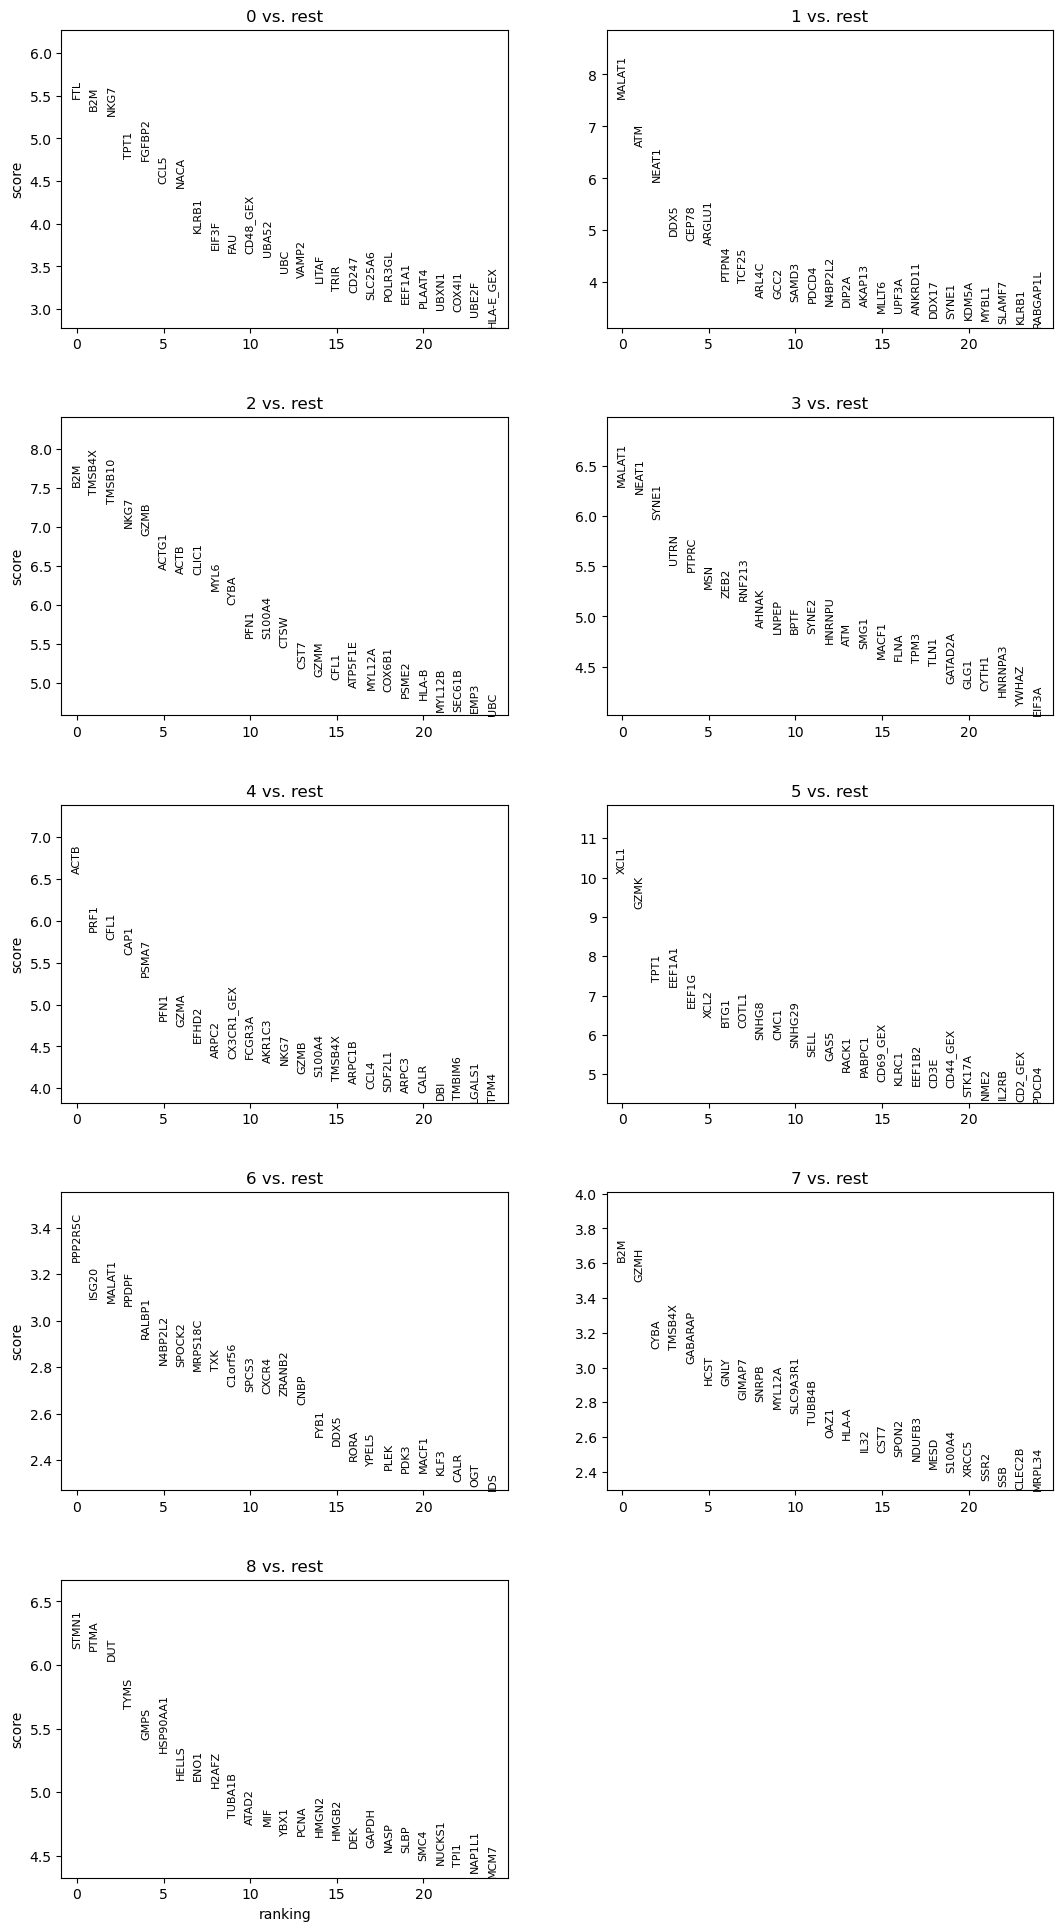

In [33]:
sc.pl.umap(adata_latent, color=['leiden_1_2'], ncols =3)

sc.tl.rank_genes_groups(adata_latent, 'leiden_1_2', method='wilcoxon')
sc.pl.rank_genes_groups(adata_latent, n_genes=25, sharey=False, ncols=2)

## Searching transitional CD56dim GZMK+ cluster

- CD56 and CD16 expression low, while GZMK and TIGIT expression high.

Low expression (proteins)


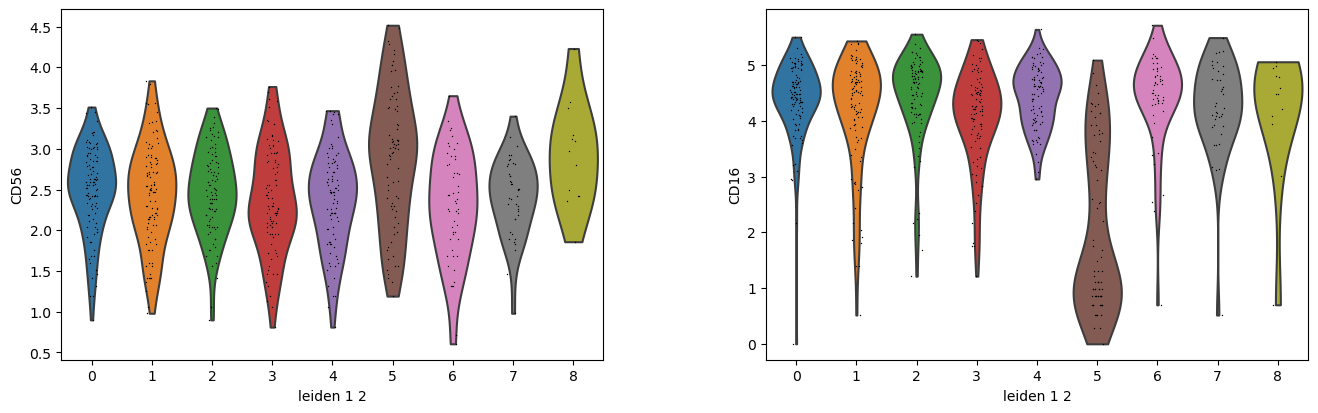

Higher expression (genes)


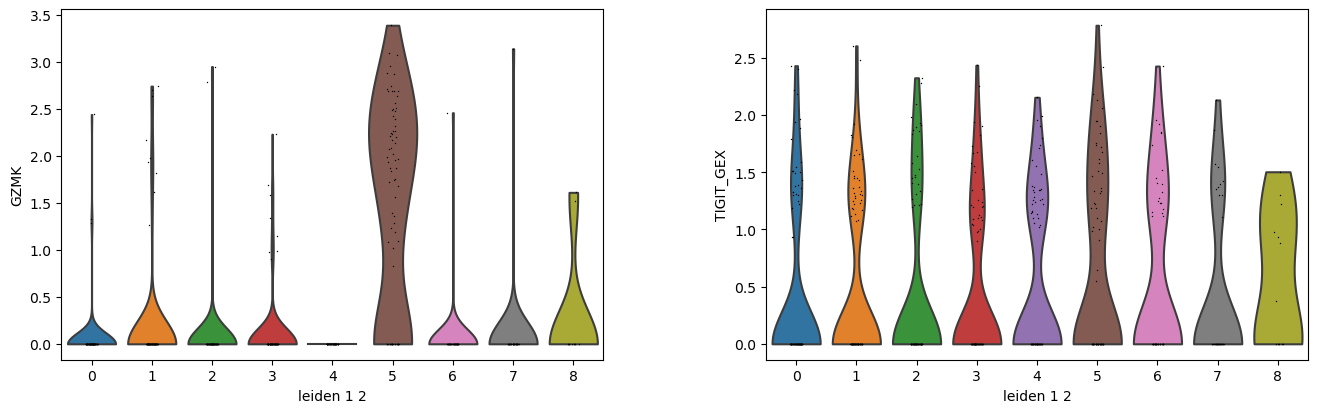

Higher expression (proteins)


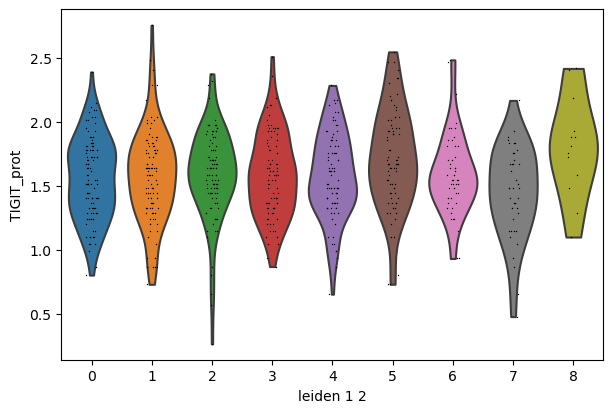

In [34]:
print("Low expression (proteins)")
sc.pl.violin(adata_latent, ['CD56', 'CD16'], groupby='leiden_1_2')

print("Higher expression (genes)")
sc.pl.violin(adata_latent, ['GZMK', 'TIGIT_GEX'], groupby='leiden_1_2')

print("Higher expression (proteins)")
sc.pl.violin(adata_latent, ['TIGIT_prot'], groupby='leiden_1_2')




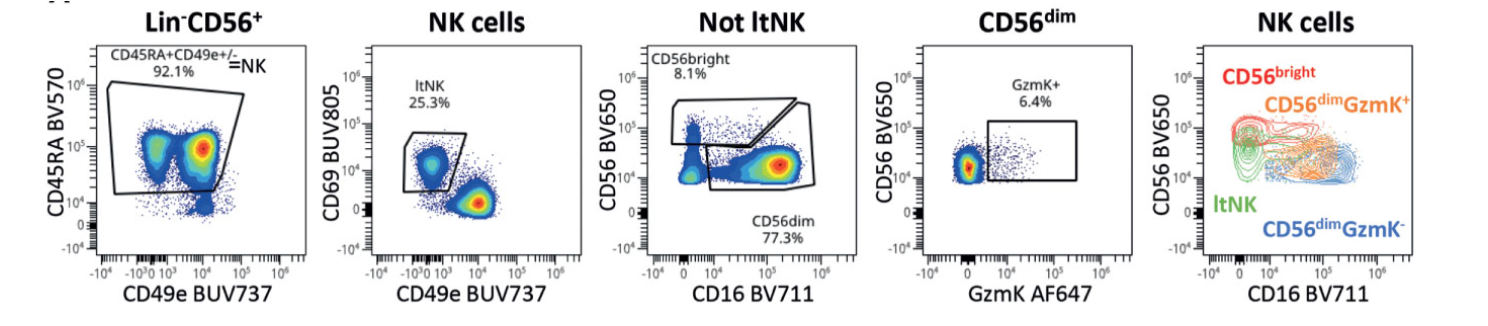

Melsen et al. (2022)

- In the paper it was presented that in the classical two-dimensional plot of CD56 against CD16, the CD56dimGzmK+ cells were positioned between the CD56bright and CD56dimGzmK- population.

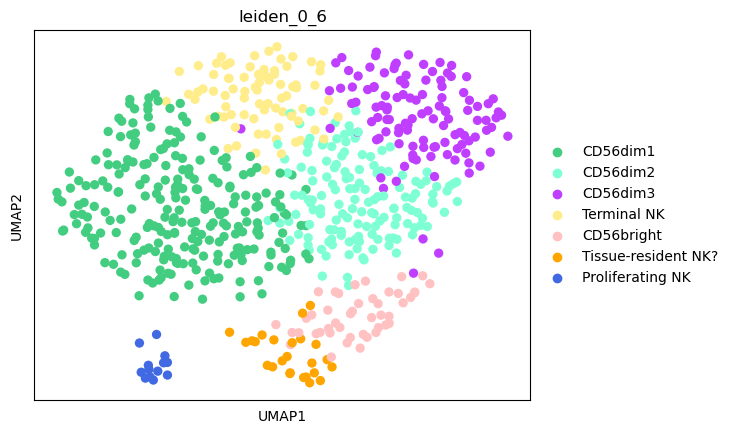

In [109]:
new_cluster_names = [
    'CD56dim1', 'CD56dim2',
    'CD56dim3', 'Terminal NK',
    'CD56bright', 'Tissue-resident NK?',
    'Proliferating NK']

adata_latent.rename_categories('leiden_0_6', new_cluster_names)

#Latent

sc.pl.umap(adata_latent, color=['leiden_0_6'])

Text(0, 0.5, 'CD56')

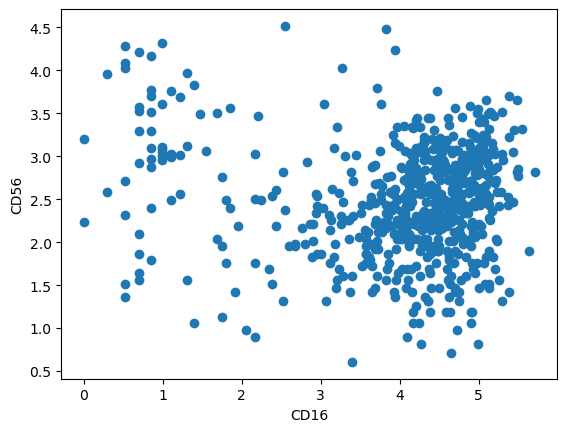

In [35]:
#Plotting proteins CD16 against CD56 

x = adata_prot['CD16']
y = adata_prot['CD56']

plt.scatter(x, y) 
plt.xlabel("CD16")
plt.ylabel("CD56")
